# Initial setting

In [0]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import datetime
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Mount your drive here by authorizing access
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Building model for lightGBM

In [0]:
!pip install lightgbm

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [0]:
# Split dataset into training data and test data
df_model = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/model_dataset.csv')
df = df_model[df_model['year']!=2017]
df_test = df_model[df_model['year']==2017]

In [0]:
df_model.head()

,index,num_crimes,year,month,nta_index,NTACode,avg6mon,PopE,MaleP,FemP,hispanicP,whiteP,blackP,asiaP,PopUnder15P,Pop15to34P,Pop35to54P,Pop55to74P,PopOver75P,otherRaceP,employedP,unemployedP,midincome,not_insP,povfamilyP,povchildP,pov65P
0,2013_BK09-1,62,2013,1,2013_BK09,BK09,77.333333,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
1,2013_BK09-2,72,2013,2,2013_BK09,BK09,75.166667,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
2,2013_BK09-3,67,2013,3,2013_BK09,BK09,71.833333,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
3,2013_BK09-4,72,2013,4,2013_BK09,BK09,69.833333,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
4,2013_BK09-5,69,2013,5,2013_BK09,BK09,67.500000,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8


In [0]:
drop_var_model = ['nta_index','year','month','index','NTACode']
df = df.drop(columns=drop_var_model)
df_test = df_test.drop(columns=drop_var_model)

## Setting for lightGBM

In [0]:
model_LGB = lgb.LGBMRegressor()

In [0]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [0]:
# grid search
parameter_range = {'num_leaves': [5, 10, 20],
                   'learning_rate': [0.01, 0.1, 1],
                   'n_estimators': [100, 200, 500],
                   'max_depth': [2, 4, 6, 8, 10, -1]}

model = GridSearchCV(model_LGB,
                     param_grid = parameter_range,
                     cv = 5,
                     scoring = 'neg_mean_squared_error')
model.fit(X, y)

# best estimator
best_model = model.best_estimator_

In [0]:
best_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=2,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=5, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
# Function for plot the results
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred']) 
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

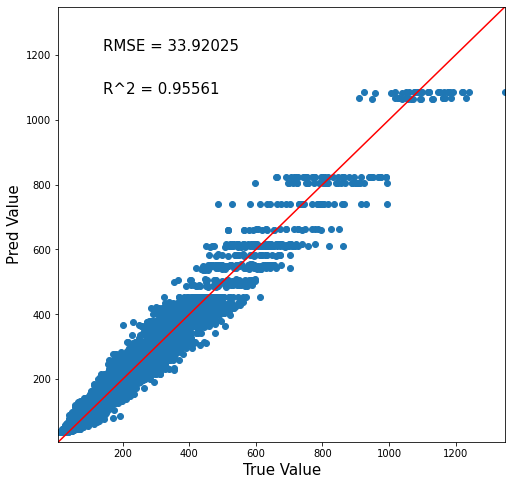

In [0]:
# APply the model to the training dataset
pred_train = best_model.predict(X)
train_y = df['num_crimes'].reset_index()
train_y.drop(columns=['index'],inplace=True)

pred_df_train = pd.concat([train_y, pd.Series(pred_train)], axis=1)
pred_df_train.columns = ['true', 'pred']
True_Pred_map(pred_df_train)

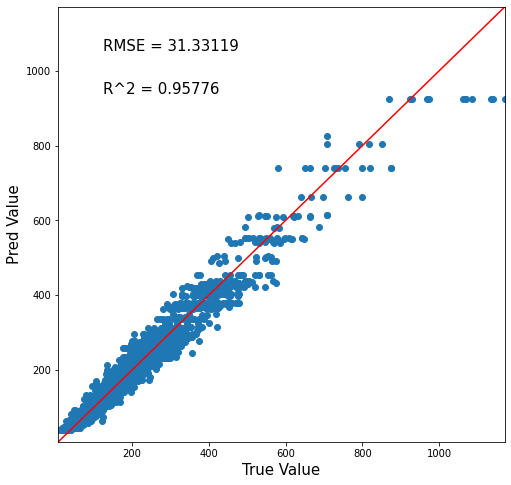

In [0]:
# Apply the model to the test dataset
pred = best_model.predict(X_test)
test_y = df_test['num_crimes'].reset_index()
test_y.drop(columns=['index'],inplace=True)

pred_df = pd.concat([test_y, pd.Series(pred)], axis=1)
pred_df.columns = ['true', 'pred']
True_Pred_map(pred_df)

In [0]:
# feature importances
fi = best_model.feature_importances_  
X_train = df.iloc[:, 1:]
fi_df = pd.DataFrame({'feature': list(X_train.columns),
                       'feature importance': fi[:]}).sort_values('feature importance', ascending = False)
fi_df

,feature,feature importance
0,avg6mon,1292
7,Pop15to34P,77
6,PopUnder15P,71
2,hispanicP,16
9,Pop55to74P,11
14,not_insP,10
13,midincome,8
16,povchildP,7
3,whiteP,6
11,otherRaceP,2


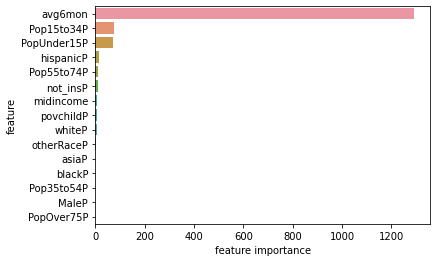

In [0]:
# Plot the feature importance
sns_plot = sns.barplot(fi_df['feature importance'][0:15],fi_df['feature'][0:15])
fig = sns_plot.get_figure()

# Optuna

In [0]:
!pip install optuna

     |████████████████████████████████| 163kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 11.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 112kB 17.4MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=471dd16cd3f6dfa701b532ae84f78075ebafdb1ca380b23ace839468672fa53d
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.3.0-cp36-none-any.whl size=221121 sha256=ff3676da99c26e0a4b83ba7942bc77ce1048b0984f7d27e2f49d931881e818f4
  Stored in directory: /root/.cache/pip/wheels/62/f

In [0]:
model_LGB = lgb.LGBMRegressor()

In [0]:
import optuna

In [0]:
X, y = df.iloc[:,1:], df.iloc[:,0]
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [0]:
# To use optuna, we divide the training data into two data.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.values
y_train = y_train.values
X_val = X_val.values
y_val = y_val.values

# Create objective function
def objective(trial):
  num_leave = trial.suggest_int('num_leaves', 5, 20, 5)
  learning = trial.suggest_uniform('learning_rate', 0.01, 0.3)
  max_depth = trial.suggest_int('max_depth', -1, 10, 2)
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 50)
  LGBR = lgb.LGBMRegressor(num_leaves=num_leave,
                           learning_rate = learning,
                           max_depth = max_depth,
                           n_estimators = n_estimators)
  LGBR.fit(X_train, y_train)
  pred = LGBR.predict(X_val)
  return np.sqrt(mean_squared_error(pred, y_val))

In [0]:
study = optuna.create_study()
study.optimize(objective, n_trials = 50)

[I 2020-04-26 15:42:24,434] Finished trial#0 with value: 30.857471093538322 with parameters: {'num_leaves': 15, 'learning_rate': 0.16857950528961702, 'max_depth': -1, 'n_estimators': 200}. Best is trial#0 with value: 30.857471093538322.
[I 2020-04-26 15:42:24,687] Finished trial#1 with value: 31.42713580184831 with parameters: {'num_leaves': 10, 'learning_rate': 0.28883066746017605, 'max_depth': 3, 'n_estimators': 150}. Best is trial#0 with value: 30.857471093538322.
[I 2020-04-26 15:42:24,953] Finished trial#2 with value: 33.53764337899942 with parameters: {'num_leaves': 10, 'learning_rate': 0.11020701545091811, 'max_depth': -1, 'n_estimators': 100}. Best is trial#0 with value: 30.857471093538322.
[I 2020-04-26 15:42:25,204] Finished trial#3 with value: 36.94021714367987 with parameters: {'num_leaves': 5, 'learning_rate': 0.21933042640996236, 'max_depth': 9, 'n_estimators': 100}. Best is trial#0 with value: 30.857471093538322.
[I 2020-04-26 15:42:25,663] Finished trial#4 with value: 3

In [0]:
# Best parameters
study.best_params

{'learning_rate': 0.12471492570459652,
 'max_depth': 7,
 'n_estimators': 200,
 'num_leaves': 15}

In [0]:
# Best RMSE
study.best_value

30.731706132126412

In [0]:
# Apply the best parameters to the model
model_LGBR = lgb.LGBMRegressor(max_depth=7,num_leaves=15,
                               n_estimators=200,learning_rate=0.12471492570459652)

In [0]:
# Function for plot the results
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred']) 
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

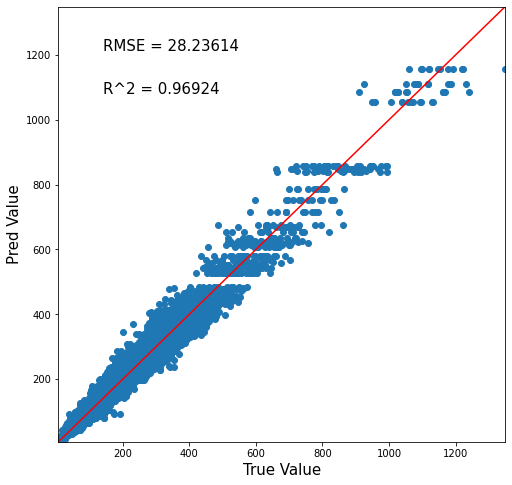

In [0]:
# Apply the model to all training data set
model_LGBR.fit(X, y)

pred_train = model_LGBR.predict(X)
train_y = df['num_crimes'].reset_index()
train_y.drop(columns=['index'],inplace=True)

pred_df_train = pd.concat([train_y, pd.Series(pred_train)], axis=1)
pred_df_train.columns = ['true', 'pred']
True_Pred_map(pred_df_train)
plt.savefig(r'/content/drive/Shared drives/STATS_507_Fianl_Project/plot_images/LGBM_train_nonave.png')

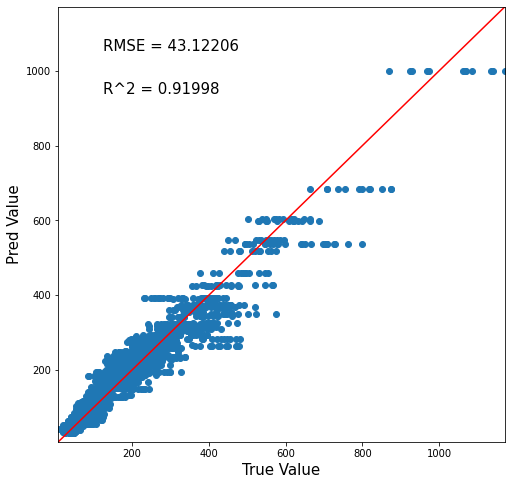

In [0]:
# Predict test data
pred = model_LGBR.predict(X_test)
test_y = df_test['num_crimes'].reset_index()
test_y.drop(columns=['index'],inplace=True)

pred_df = pd.concat([test_y, pd.Series(pred)], axis=1)
pred_df.columns = ['true', 'pred']
True_Pred_map(pred_df)
plt.savefig(r'/content/drive/Shared drives/STATS_507_Fianl_Project/plot_images/LGBM_test_nonave.png')

In [0]:
# feature importances
fi = model_LGBR.feature_importances_  
X_train = df.iloc[:, 1:]
fi_df = pd.DataFrame({'feature': list(X_train.columns),
                       'feature importance': fi[:]}).sort_values('feature importance', ascending = False)
fi_df

,feature,feature importance
0,PopE,222
3,hispanicP,203
9,Pop35to54P,173
6,asiaP,171
5,blackP,169
1,MaleP,165
15,midincome,155
11,PopOver75P,146
8,Pop15to34P,143
16,not_insP,142


In [0]:
# Plot the feature importance
sns_plot = sns.barplot(fi_df['feature importance'][0:15],fi_df['feature'][0:15])
fig = sns_plot.get_figure()
plt.savefig(r'/content/drive/Shared drives/STATS_507_Fianl_Project/plot_images/LGBM_features_nonave.png')

# Drop average 6 month

In [0]:
drop_var_model = ['nta_index','year','month','index','NTACode','avg6mon']
df = df.drop(columns=drop_var_model)
df_test = df_test.drop(columns=drop_var_model)

In [0]:
X, y = df.iloc[:,1:], df.iloc[:,0]
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [0]:
# To use optuna, we divide the training data into two data.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.values
y_train = y_train.values
X_val = X_val.values
y_val = y_val.values

# Create objective function
def objective(trial):
  num_leave = trial.suggest_int('num_leaves', 5, 20, 5)
  learning = trial.suggest_uniform('learning_rate', 0.01, 0.3)
  max_depth = trial.suggest_int('max_depth', -1, 10, 2)
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 50)
  LGBR = lgb.LGBMRegressor(num_leaves=num_leave,
                           learning_rate = learning,
                           max_depth = max_depth,
                           n_estimators = n_estimators)
  LGBR.fit(X_train, y_train)
  pred = LGBR.predict(X_val)
  return np.sqrt(mean_squared_error(pred, y_val))

In [0]:
study = optuna.create_study()
study.optimize(objective, n_trials = 50)

In [0]:
# Best parameters
study.best_params

In [0]:
# Best RMSE
study.best_value

In [0]:
# Apply the best parameters to the model
model_LGBR = lgb.LGBMRegressor(max_depth=7,num_leaves=15,
                               n_estimators=200,learning_rate=0.12471492570459652)

In [0]:
# Apply the model to all training data set
model_LGBR.fit(X, y)

pred_train = model_LGBR.predict(X)
train_y = df['num_crimes'].reset_index()
train_y.drop(columns=['index'],inplace=True)

pred_df_train = pd.concat([train_y, pd.Series(pred_train)], axis=1)
pred_df_train.columns = ['true', 'pred']
True_Pred_map(pred_df_train)
plt.savefig(r'/content/drive/Shared drives/STATS_507_Fianl_Project/plot_images/LGBM_train_nonave.png')

In [0]:
# Predict test data
pred = model_LGBR.predict(X_test)
test_y = df_test['num_crimes'].reset_index()
test_y.drop(columns=['index'],inplace=True)

pred_df = pd.concat([test_y, pd.Series(pred)], axis=1)
pred_df.columns = ['true', 'pred']
True_Pred_map(pred_df)
plt.savefig(r'/content/drive/Shared drives/STATS_507_Fianl_Project/plot_images/LGBM_test_nonave.png')

In [0]:
# feature importances
fi = model_LGBR.feature_importances_  
X_train = df.iloc[:, 1:]
fi_df = pd.DataFrame({'feature': list(X_train.columns),
                       'feature importance': fi[:]}).sort_values('feature importance', ascending = False)
fi_df

In [0]:
# Plot the feature importance
sns_plot = sns.barplot(fi_df['feature importance'][0:15],fi_df['feature'][0:15])
fig = sns_plot.get_figure()
plt.savefig(r'/content/drive/Shared drives/STATS_507_Fianl_Project/plot_images/LGBM_features_nonave.png')